## Weight & Biases
Zur Nachverfolgung und Analyse der Model-Performance

### Dataset & Runs
Namen für Datensets und Runs für bessere Nachvollziehbarkeit auf wandb

#### Runs
- **gb-hnf-uc**: Gradient Boosting mit HNF & UsageCluster
- **gb-hnf-cu**: Gradient Boosting mit HNF & Combined Usage


### Gradient Boosting
Imports & Datensatz laden

86
{'test_r2_mean': 0.6752542045654825}
{'test_neg_mean_absolute_percentage_error_mean': -0.3868312824759806}
{'test_neg_root_mean_squared_error_mean': -1893.2660980864173}
{'test_neg_mean_absolute_error_mean': -874.9051044415539}
{'test_max_error_mean': -6567.637927474642}


,area_total_floor_416,num_floors_underground,num_floors_overground,garage_indoor,total_expenses,volume_total_416,x0_ANDERES,x0_AUSSENANLAGEN,x0_BEHERBERGUNG,x0_BETRIEB,x0_BUERO,x0_GESUNDHEIT,x0_HALLEN,x0_IRRELEVANT,x0_KULTUS_KULTUR,x0_OFFENE_BAUTEN,x0_SCHULEN,x0_TECHNIK,x0_WOHNEN
0,10250.0,2.0,8.0,1.0,3.046910e+07,33816.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1996.0,1.0,2.0,1.0,7.000000e+06,8005.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2520.0,1.0,6.7,0.0,9.997500e+06,7420.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5945.0,1.0,3.0,0.0,1.609992e+07,44016.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,6195.0,1.0,3.0,0.0,2.403826e+07,29104.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,4943.0,1.0,2.0,0.0,1.837123e+07,24075.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,18437.0,1.0,6.0,1.0,3.826000e+07,59720.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11,565.0,1.0,1.5,0.0,2.871631e+06,2200.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12,1499.0,1.0,2.0,0.0,6.283709e+06,5312.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14,8748.0,2.0,6.0,0.0,2.987028e+07,31130.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


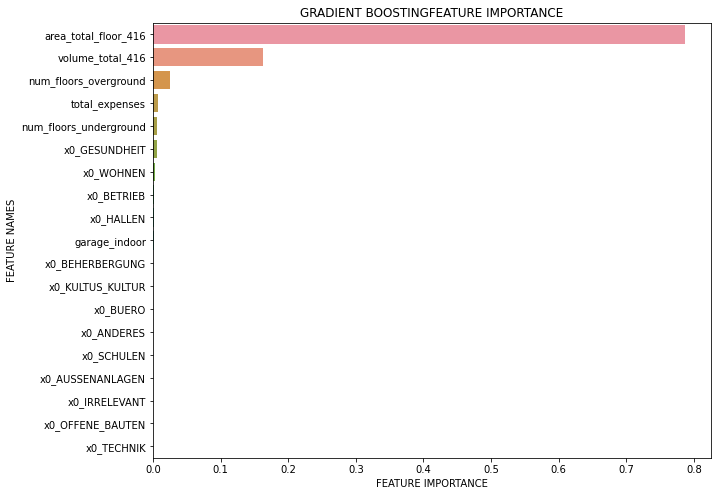

In [1]:
from typing import Final
import wandb
import pandas as pd
from numpy import mean

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from joblib import load

import src.package.consts as c
import src.package.shared as sh
import src.package.charts as charts
import src.package.importer as im
import src.package.importer_usages as imp_usg
import src.package.ml_helper as ml_helper

pd.set_option('display.max_rows', 500)  # to show all value_counts

# load dataset
df = im.get_extended_dataset('../package/datasets/test_set.csv')
df = imp_usg.extract_usage_details(df)
df = imp_usg.extract_garage_details(df)
# df = ml_helper.remove_outliers(df, factor=2.3)
print(df[c.FIELD_ID].count())

# load transform pipeline for test_set
pipeline = load(sh.export_directory_path(f'transform_pipeline.joblib'))
X, y = ml_helper.hnf_dataset_full(df, fitted_pipeline=pipeline)
# X, y = ml_helper.hnf_dataset_full(df)

# wandb.login()

MODEL_GRADIENT_BOOSTING: Final = 'GradientBoosting'
MODEL_LINEAR_REGRESSION: Final = 'LinearRegression'
current_model = MODEL_GRADIENT_BOOSTING

TAG_TRAIN_SET: Final = 'train-set'
TAG_TEST_SET: Final = 'test-set'

# config
config = {
     'model': current_model,
     'features': ', '.join(X.columns.values),
     'dataset-count': len(X.index),
     'description': 'Impute volume 416 (clustered), Removed outliers (2.3), Drop all, OneHotEncoding, Default Hyperparameter'
}
# wandb.init(project='Metriken Bauwesen', entity='devcore', config=config, tags=[TAG_TRAIN_SET])

# train and evaluate model
regr = GradientBoostingRegressor(random_state=0)
# regr = linear_model.LinearRegression()
scores_map = ml_helper.cross_validation(regr, X, y)

# log result of cross validation to wandb
for key in scores_map.keys():
     if key in {'fit_time', 'score_time'}:
         continue
     scores = scores_map[key]
     # wandb.log({f'{key}_mean': mean(scores)})
     print({f'{key}_mean': mean(scores)})

# use wandb regression eval
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
regr.fit(X_train, y_train)

# wandb.sklearn.plot_regressor(regr, X_train, X_test, y_train, y_test, model_name=current_model)

charts.plot_feature_importance(regr.feature_importances_, X.columns, 'GRADIENT BOOSTING')
X